In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset

from desc.backend import jnp
from desc.compute import compute_rotational_transform, data_index
from desc.equilibrium import Equilibrium
from desc.grid import ConcentricGrid, LinearGrid, QuadratureGrid
import desc.io
from desc.plotting import plot_1d
from desc.profiles import PowerSeriesProfile
from desc.transform import Transform
from desc.vmec import VMECIO

np.set_printoptions(precision=3, floatmode="fixed")
jnp.set_printoptions(precision=3, floatmode="fixed")

DESC version 0.5.1+109.g58e5f52.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 6.07 GB available memory


## Visualizing different grids

In [3]:
rng = np.random.default_rng()
L = rng.integers(low=1, high=30)
M = rng.integers(low=1, high=30)
N = rng.integers(low=1, high=30)
NFP = rng.integers(low=1, high=30)
sym = True if rng.integers(2) > 0 else False
random_grid = ConcentricGrid(L=L, N=N, M=M, NFP=1)
random_grid_2 = QuadratureGrid(L=L, N=N, M=M, NFP=1)

In [4]:
def print_grid(grid, stop=None, quantity=None):
    """
    Parameters
    ----------
    grid
        Prints nodes and spacing.
    stop : int
        Max number of nodes to print. Defaults to entire grid.
    quantity : ndarray
        A quantity to print alongside the grid. i.e. data["iota"]
    """
    assert (
        len(grid.nodes) // grid.num_zeta
        == jnp.where(~jnp.isclose(grid.nodes[:, 2], 0))[0][0]
    )
    print(grid.L, grid.M, grid.N, grid.NFP, grid.sym, grid.node_pattern)
    print(grid.num_rho, grid.num_theta, grid.num_zeta)
    print("nodes", "             ", "spacing")
    if stop is None:
        stop = len(grid.nodes)
    if quantity is None:
        for i, e in enumerate(zip(grid.nodes, grid.spacing)):
            a, b = e
            print(a, b)
            if i > stop:
                break
    else:
        for i, e in enumerate(zip(grid.nodes, grid.spacing, quantity)):
            a, b, c = e
            print(a, b, c)
            if i > stop:
                break

(<Figure size 384x384 with 1 Axes>,
 <PolarAxesSubplot:title={'center':'LinearGrid, $L=10$, $M=1, pattern: linear$'}>)

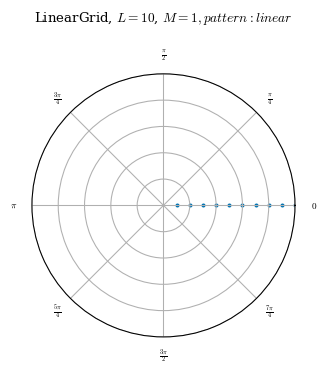

In [5]:
# print_grid(random_grid, stop=50)
desc.plotting.plot_grid(LinearGrid(rho=jnp.linspace(1 / 10, 1, 10)))

In [6]:
def get_concentric_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return ConcentricGrid(
        L=eq.L_grid,
        M=eq.M_grid,
        N=eq.N_grid,
        NFP=1,  # to avoid known grid bug
        sym=False,
        node_pattern=eq.node_pattern,
    )


def get_quad_grid(eq):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    ConcentricGrid
        Concentric grid used by the given equilibrium.
    """
    return QuadratureGrid(
        L=2 * eq.L_grid + 1,
        M=2 * eq.M_grid + 1,
        N=2 * eq.N_grid + 1,
        NFP=1,  # to avoid known grid bug
    )


def get_vmec_plot(name):
    """
    Parameters
    ----------
    name : str
        Name of the equilibrium.

    Returns
    -------
    rho : ndarray
        rho values. x-axis of plot.
    iota : ndarray
        iota. y-axis of plot.
    """
    f = Dataset("edu-vmec/input-current/wout_" + name + ".nc")
    iota = jnp.asarray(f.variables["iotaf"])
    rho = jnp.sqrt(f.variables["phi"] / np.array(f.variables["phi"])[-1])
    return rho, iota


def plot(x, y, prepend_title):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 5 if len(x) > 64 else 10
    y = np.atleast_2d(y)
    fig, ax = plt.subplots(ncols=y.shape[0], figsize=(y.shape[0] * 8, 5))
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size)
        ax[i].plot(x, y[i, :])
        ax[i].set(
            yscale="symlog",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title=prepend_title + " iota" + append,
            facecolor="white",
        )
        ax[i].grid()


def plot_overlay(x, y, prepend_title, x2, y2, prepend_title_2, dpi=200, log=False):
    """
    Parameters
    ----------
    x : ndarray
        plot x-axis.
    y : ndarray
        plot y-axis. will make multiple plots if y.ndim > 1
    prepend_title : str
        string to prepend to plot title
    """
    dot_size = 2 if len(x) > 128 else 5
    y = np.atleast_2d(y)
    y2 = np.atleast_2d(y2)
    fig, ax = plt.subplots(dpi=dpi)
    ax = np.atleast_1d(ax)

    for i in range(y.shape[0]):
        append = " " + str(i) + " derivative wrt rho"
        ax[i].scatter(x, y[i, :], s=dot_size, label=prepend_title)
        ax[i].plot(x, y[i, :])
        ax[i].scatter(x2, y2[i, :], s=dot_size, label=prepend_title_2)
        ax[i].plot(x2, y2[i, :])
        ax[i].set(
            yscale="log" if log else "linear",
            xlabel=r"$\rho$",
            ylabel="iota" + append,
            title="iota" + append,
            facecolor="white",
        )
        ax[i].grid()
    fig.legend()

## torus test case

In [7]:
zero_current = PowerSeriesProfile(params=[0], modes=[0], grid=random_grid)
finite_current = PowerSeriesProfile(params=[1e7], modes=[2], grid=random_grid)
zero_current_torus = Equilibrium(current=zero_current)
finite_current_torus = Equilibrium(current=finite_current)

grid_1d = LinearGrid(rho=random_grid.nodes[random_grid.unique_rho_indices, 0])
plot_1d(zero_current_torus, "iota", grid=grid_1d)
print_grid(
    random_grid,
    stop=10,
    quantity=zero_current_torus.compute("iota", grid=grid_1d)["iota"],
)
print()
plot_1d(finite_current_torus, "iota", grid=grid_1d)
print_grid(
    random_grid,
    stop=10,
    quantity=finite_current_torus.compute("iota", grid=grid_1d)["iota"],
)

1 19 17 1 False jacobi
1 57 35
nodes               spacing
[0.667 0.000 0.000] [1.000 0.110 0.180] -0.0

1 19 17 1 False jacobi
1 57 35
nodes               spacing
[0.667 0.000 0.000] [1.000 0.110 0.180] -421.10312134238427


## Functions to compute iota using bootstrap method.
Let's call this testing method the bootstrap method: where we use the current computed on an equilibrium solved from an input with iota coefficients to recompute iota with the new method.

This should give the same result for iota and confirm that DESC is internally consistent. But the results differ.

In [8]:
def get_transform(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        Concentric grid used by the given equilibrium.

    Returns
    -------
    Transform
         R_transform, Z_transform, L_transform of the given equilibrium.
    """
    R_transform = Transform(
        grid, eq.R_basis, derivs=data_index["iota"]["R_derivs"], build=True
    )
    Z_transform = Transform(
        grid, eq.Z_basis, derivs=data_index["iota"]["R_derivs"], build=True
    )
    L_transform = Transform(
        grid, eq.L_basis, derivs=data_index["iota"]["L_derivs"], build=True
    )
    return R_transform, Z_transform, L_transform


def get_toroidal_current(eq, grid):
    """
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.
    grid : ConcentricGrid
        The grid for the power series profile.

    Returns
    -------
    current : ndarray
        The toroidal current in tesla-meters at each unique rho surface of the given equilibrium.
    """
    current = np.empty(grid.num_rho)
    for i, r in enumerate(grid.nodes[grid.unique_rho_indices, 0]):
        data = eq.compute("I", grid=LinearGrid(rho=np.atleast_1d(r)))
        current[i] = data["I"]
    assert jnp.isfinite(current).all()
    return current


def get_iota(eq):
    """
    Get iota using the current from data["I"] as constraint.
    Parameters
    ----------
    eq : Equilibrium
        The equilibrium.

    Returns
    -------
    iota : ndarray
        The computed rotational transform.
    """
    grid = get_quad_grid(eq)
    transform = get_transform(eq, grid)
    return compute_rotational_transform(
        eq.R_lmn,
        eq.Z_lmn,
        eq.L_lmn,
        i_l=None,  # random value, won't be used
        c_l=None,  # random value, won't be used
        Psi=eq.Psi,
        R_transform=transform[0],
        Z_transform=transform[1],
        L_transform=transform[2],
        iota=None,  # to force compute with new function
        current=1,  # random value, won't be used
        current_from_solved_eq=get_toroidal_current(eq, grid),
    )

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_current' was not loaded.
  warnings.warn(


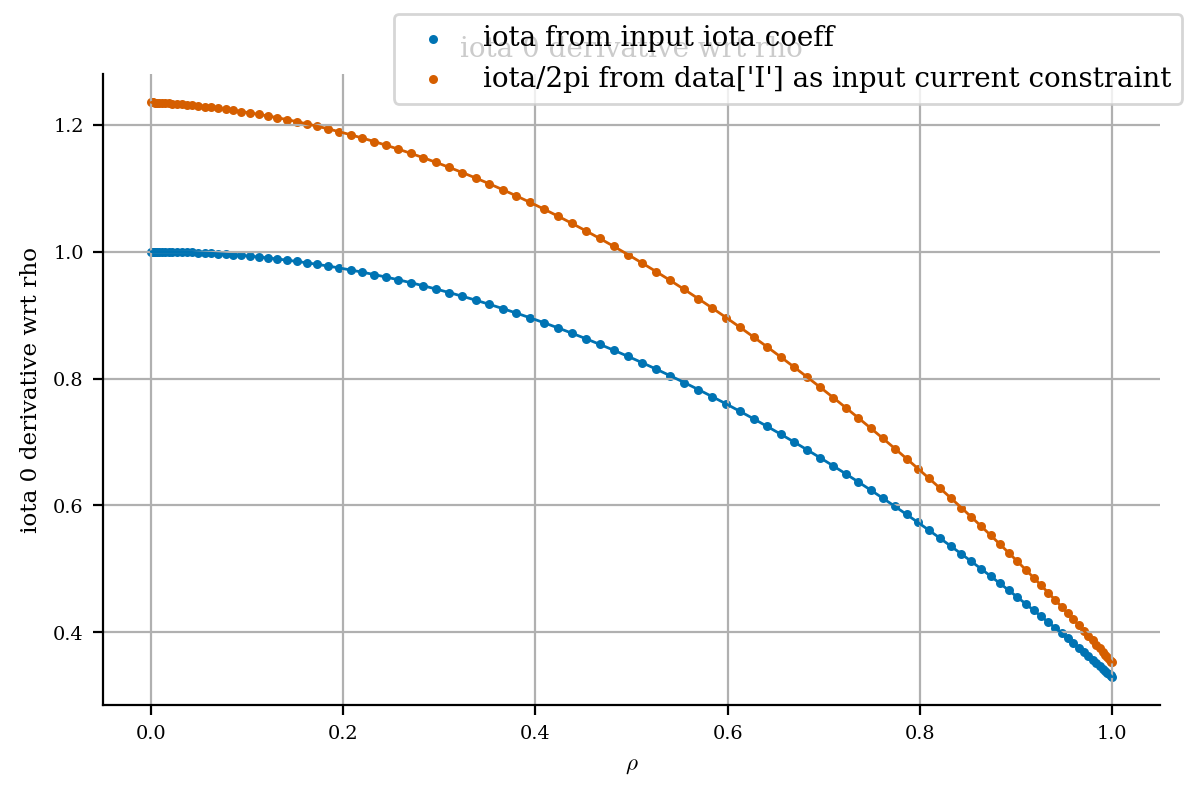

In [9]:
eq = desc.io.load("../examples/DESC/" + "DSHAPE" + "_output.h5")[-1]
# conc_grid = get_concentric_grid(eq)
quad_grid = get_quad_grid(eq)

rho = quad_grid.nodes[quad_grid.unique_rho_indices, 0]
iota_from_coef = eq.compute("iota", grid=quad_grid)["iota"][
    quad_grid.unique_rho_indices
]
iota = get_iota(eq)["iota"][quad_grid.unique_rho_indices]
plot_overlay(
    rho,
    iota_from_coef,
    "iota from input iota coeff",
    rho,
    iota
    / (
        2 * jnp.pi
    ),  # really don't think this factor of 2pi should be here, but it makes plots look closer.
    "iota/2pi from data['I'] as input current constraint",
)

## compute iota from equilibrium solved with current coeff in input file
On some of these inputs either the DESC or VMEC solver just fails and exits early.
See the readme in the input file directories for the list specifying which ones.
It's a good idea to read this because it would explain why some plots look weird.
There's no point in comparing VMEC and DESC if one or the other does not finish solving.

In [10]:
names = (
    "DSHAPE",
    "ESTELL",
    "HELIOTRON",
    "QAS",
    "SOLOVEV",
    "WISTELL-A",
)

In [11]:
# don't think edu-vmec has the correct variable naming scheme for this
# see if boundary shapes are different
# for name in names:
#     VMECIO.plot_vmec_comparison(
#         equil="../examples/DESC/input-current/" + name + "_output.h5",
#         vmec_data="edu-vmec/input-current/wout_" + name + ".nc",
#     )

/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(
/home/kaya/Documents/edu/pton/plasma/DESC/desc/io/hdf5_io.py:108: RuntimeWarning: Save attribute '_iota' was not loaded.
  warnings.warn(


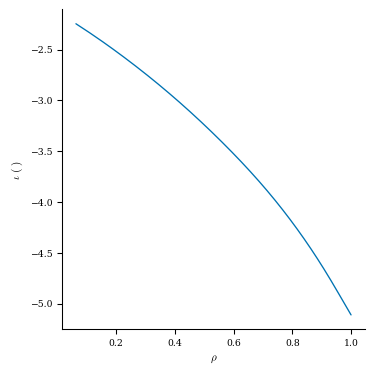

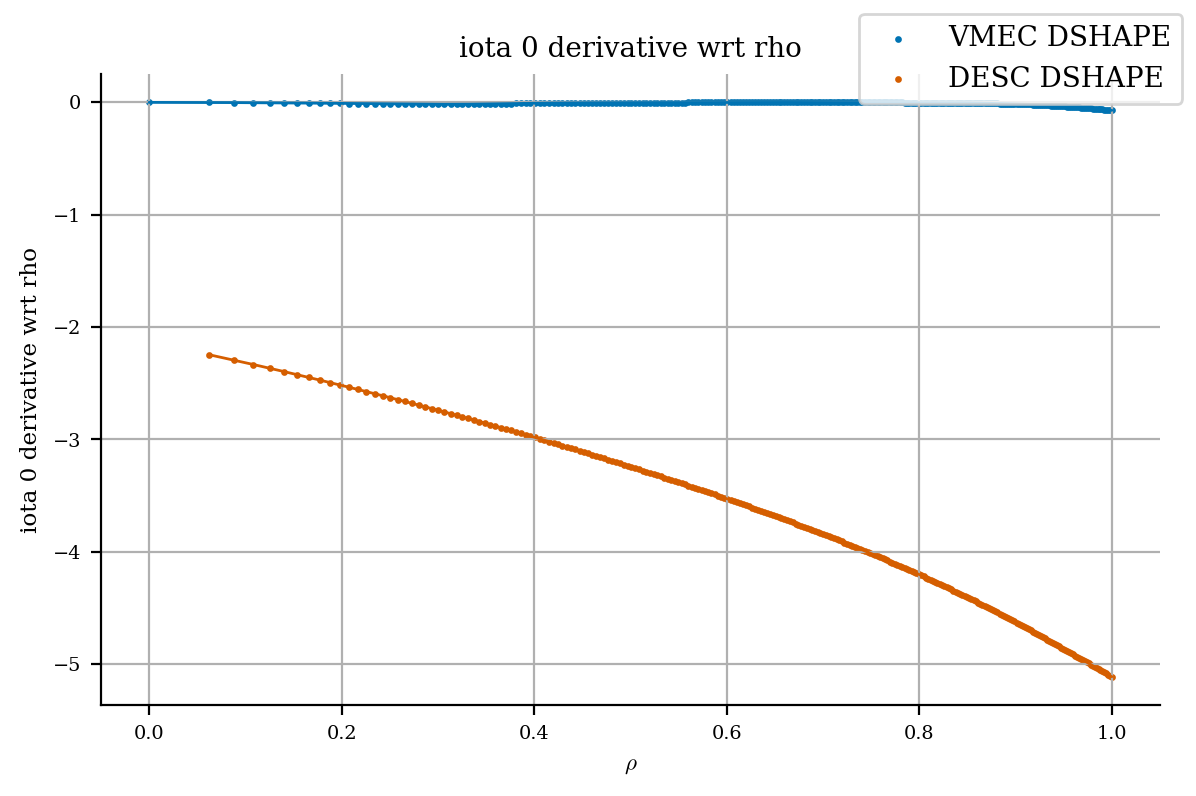

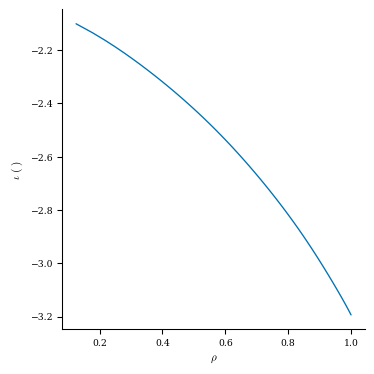

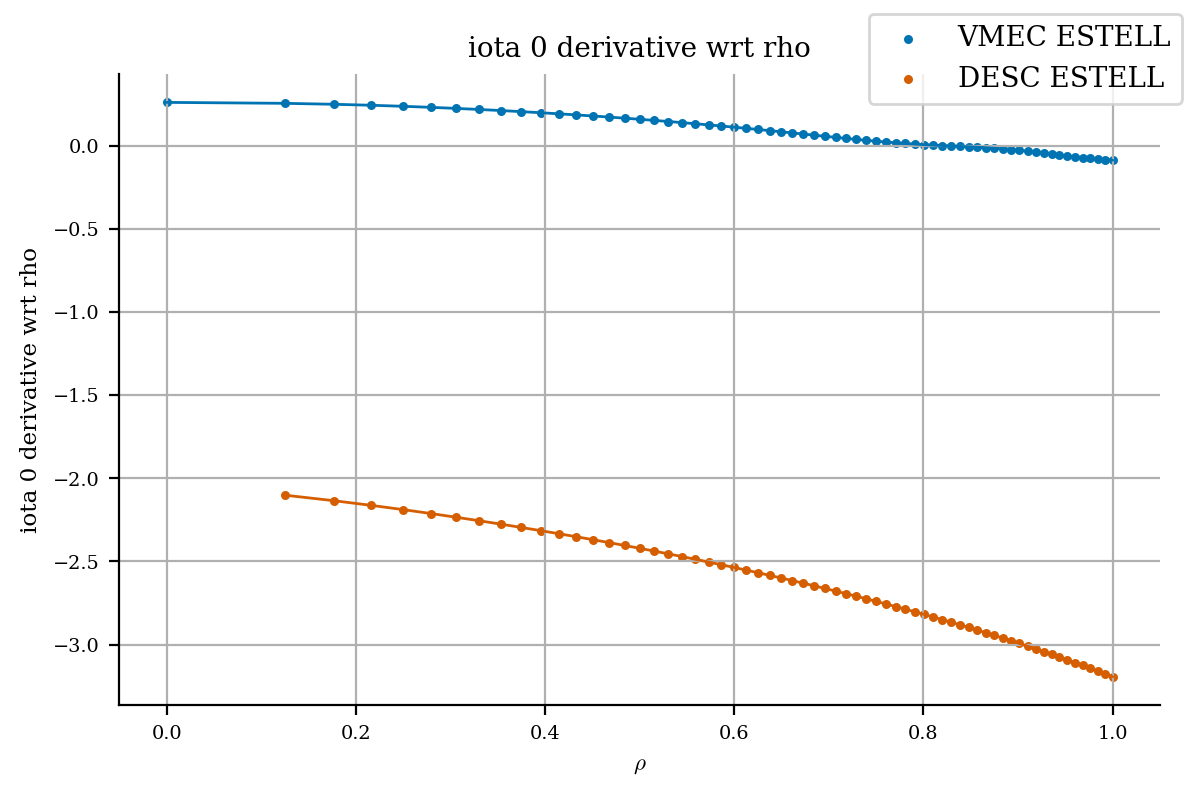

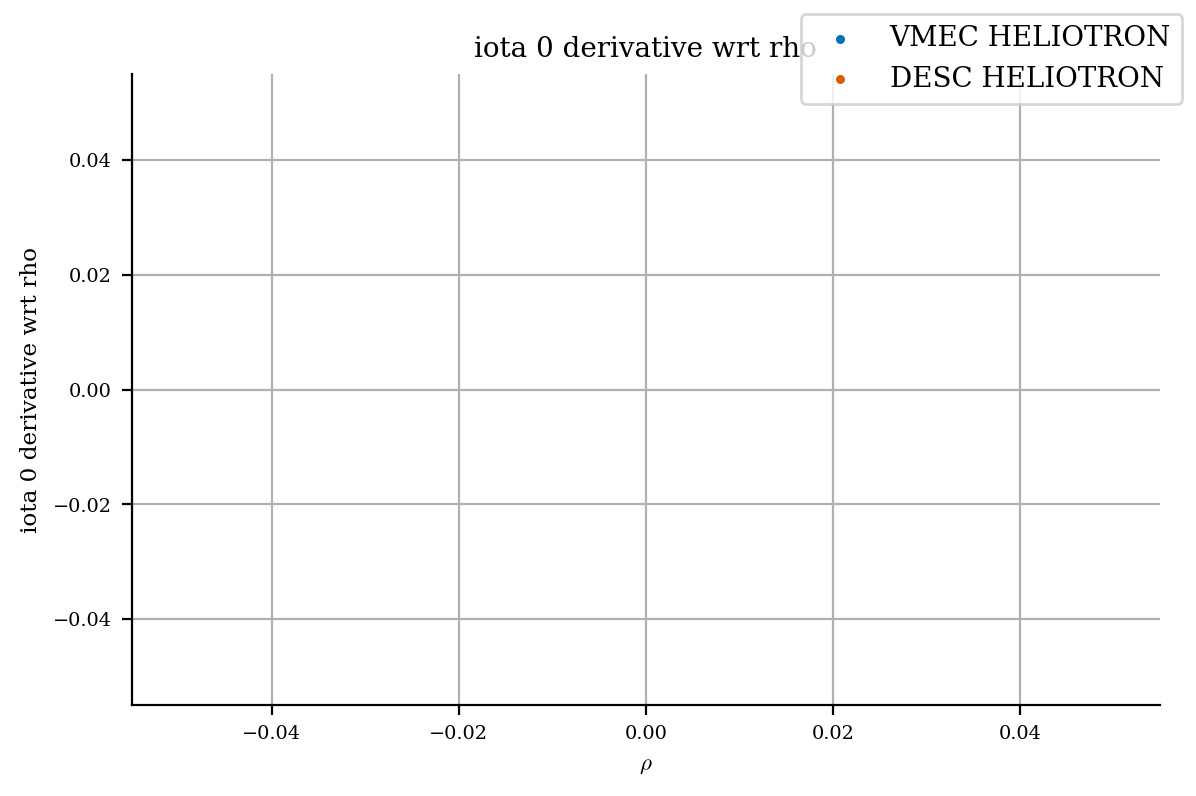

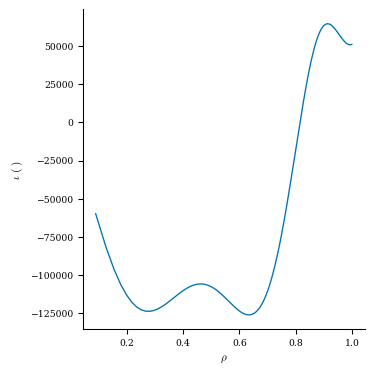

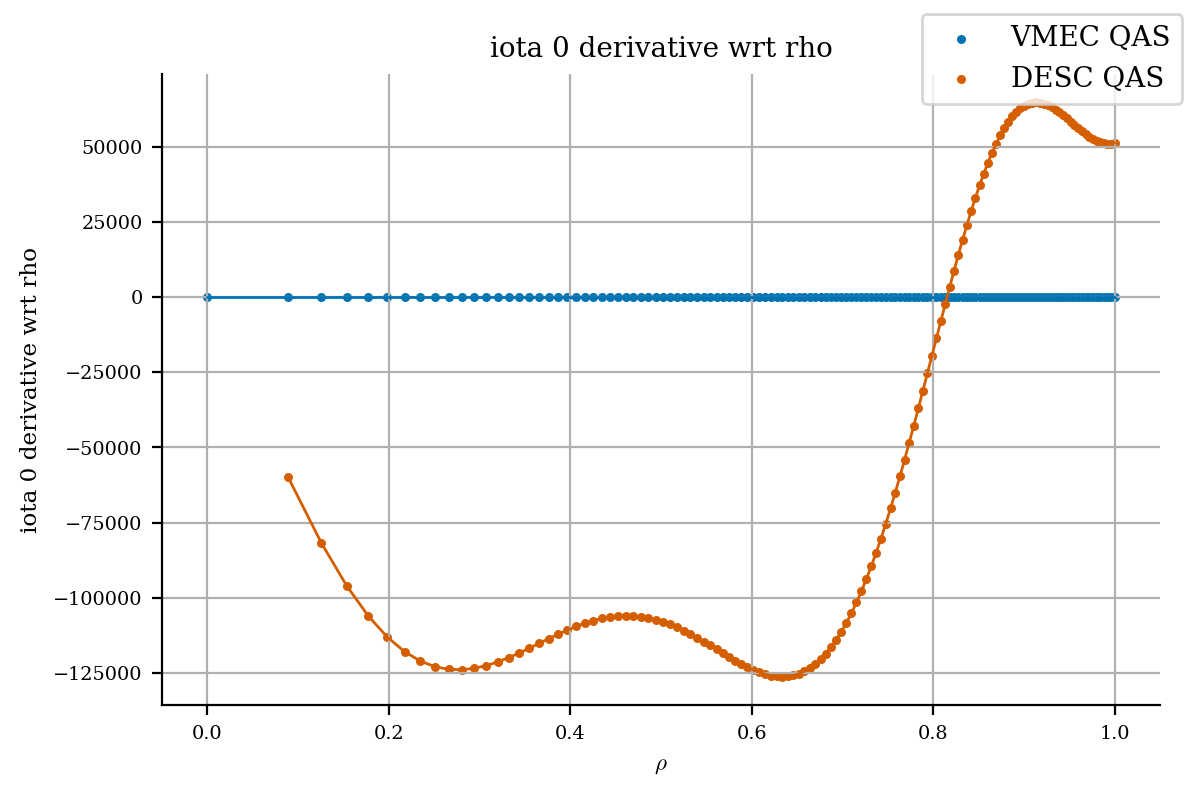

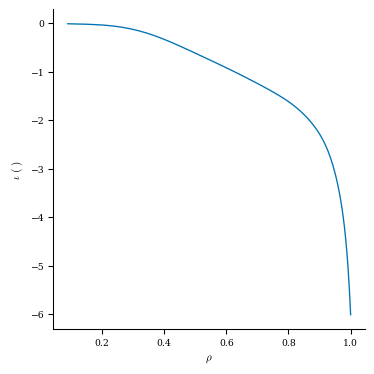

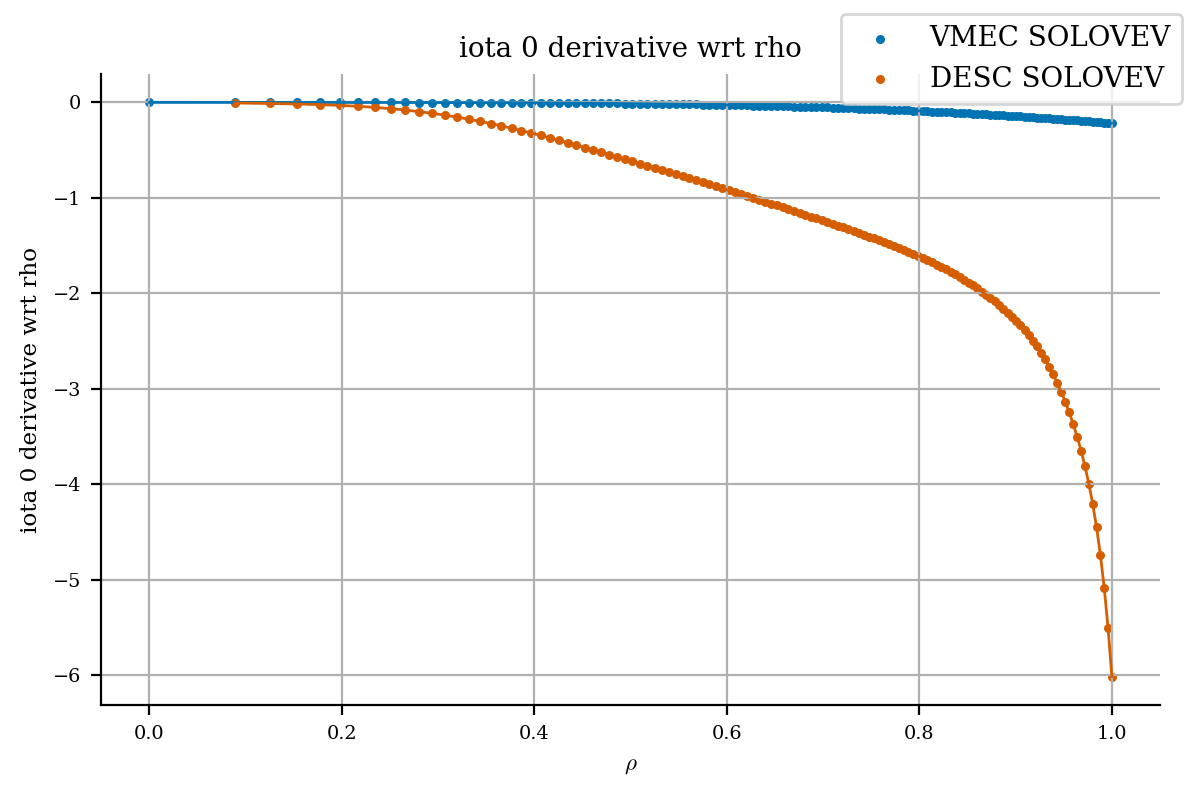

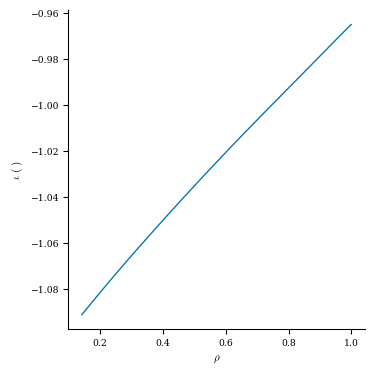

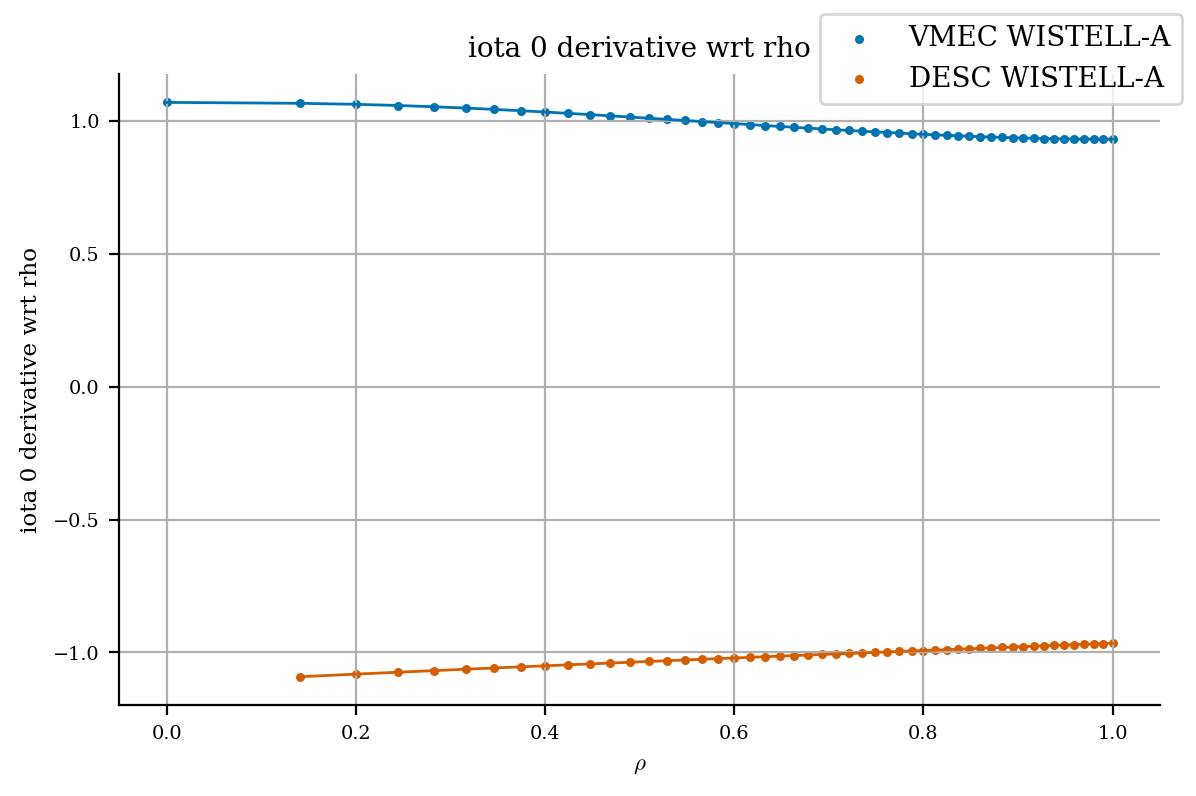

In [12]:
for name in names:
    rho, iota = get_vmec_plot(name)
    grid = LinearGrid(rho=rho)
    eq = desc.io.load("../examples/DESC/input-current/" + name + "_output.h5")[-1]
    plot_1d(eq, "iota", grid=grid)
    iota_desc = eq.compute("iota", grid=grid)["iota"]
    plot_overlay(
        rho,
        iota,
        "VMEC " + name,
        rho,
        iota_desc,
        "DESC " + name,
    )